This notebook tries to replicate what is done [here](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/style_transfer_2d.ipynb)  but in Pytorch.

Reference: [Distill.pub / Differentiable Parameterizations](https://distill.pub/2018/differentiable-parameterizations/#section-styletransfer)

In [29]:
%matplotlib inline

%load_ext autoreload
%autoreload 2


import torch
#import tensorflow as tf

from torchvision import models

import numpy as np

# from lucid.modelzoo import vision_models
# from lucid.misc.io import show, load, save

# import lucid.optvis.objectives as objectives
# import lucid.optvis.param as param
# import lucid.optvis.render as render

import PIL.Image
import urllib

import matplotlib.pyplot as plt

from visualization.lucidtorch import images

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Inception V1 is GoogLeNet according to [this](https://pytorch.org/docs/stable/torchvision/models.html#id23)

In [27]:
model = models.googlenet(pretrained=True)

In [32]:
def load(url):
    img = PIL.Image.open(urllib.request.urlopen(url))
    return np.array(img)

(512, 512, 3) (512, 645, 3)


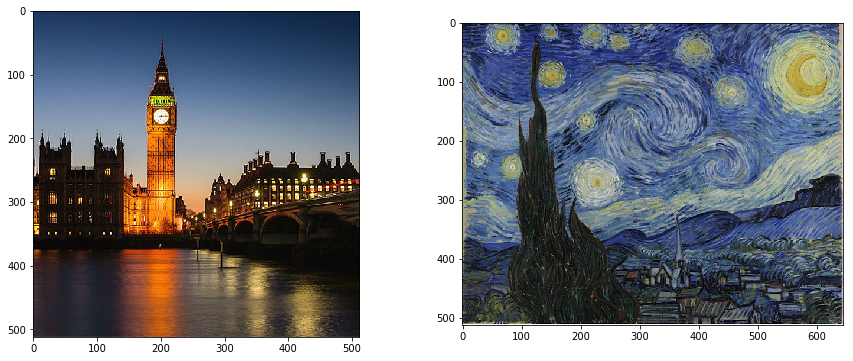

In [37]:
# how to load images from URLs?

content_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-bigben.jpg")
style_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/starry-night.png")[..., :3] # removes transparency channel

print(content_image.shape, style_image.shape)

_, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].imshow(content_image)
ax[1].imshow(style_image)

In [4]:
type(content_image)

numpy.ndarray

The InceptionV1 layers from TF are like this: (compare with the Pytorch model)

```
[Layer (belonging to InceptionV1) <conv2d0: 64> ([{'conv'}]),
  Layer (belonging to InceptionV1) <conv2d1: 64> ([{'conv'}]),
  Layer (belonging to InceptionV1) <conv2d2: 192> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed3a: 256> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed3b: 480> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4a: 508> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4b: 512> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4c: 512> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4d: 528> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4e: 832> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed5a: 832> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed5b: 1024> ([{'conv'}]),
  Layer (belonging to InceptionV1) <head0_bottleneck: 128> ([{'conv'}]),
  Layer (belonging to InceptionV1) <nn0: 1024> ([{'dense'}]),
  Layer (belonging to InceptionV1) <softmax0: 1008> ([{'dense'}]),
  Layer (belonging to InceptionV1) <head1_bottleneck: 128> ([{'conv'}]),
  Layer (belonging to InceptionV1) <nn1: 1024> ([{'dense'}]),
  Layer (belonging to InceptionV1) <softmax1: 1008> ([{'dense'}]),
  Layer (belonging to InceptionV1) <softmax2: 1008> ([{'dense'}])]
 19
 ```
 
 And the layers to plug into are:
 ```
 style_layers = [
  'conv2d2',  # conv3
  'mixed3a',  # inception3a
  'mixed4a',  # inception3b
  'mixed4b',  # inception4b
  'mixed4c',  # inception4c
]

content_layers = [
  'mixed3b',  # inception3b
]
 ```

In [5]:
print('\n'.join(model._modules.keys()))

conv1
maxpool1
conv2
conv3
maxpool2
inception3a
inception3b
maxpool3
inception4a
inception4b
inception4c
inception4d
inception4e
maxpool4
inception5a
inception5b
avgpool
dropout
fc


In [6]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [7]:
len(model._modules)

19

In [8]:
style_layers = [
  'conv3'
  'inception3a',
  'inception4a',
  'inception4b',
  'inception4c',
]

content_layers = [
  'inception3b',
]

In [22]:
import torchvision.transforms as T

# def tf_to_numpy(t):
#     with tf.Graph().as_default() as graph, tf.Session() as sess:
#         tf.global_variables_initializer().run()
#         return sess.run(t)

def style_transfer_param(content_image, style_image, decorrelate=True, fft=True):
    #style_transfer_input = param.image(*content_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
    style_transfer_input = images.image(*content_image.shape[:2], decorrelate=decorrelate, fft=fft)[0]
    # print(type(style_transfer_input))
    # style_transfer_input = torch.from_numpy(tf_to_numpy(style_transfer_input))
    #style_transfer_input = torch.from_numpy(style_transfer_input.numpy())
    
    content_tfms = T.ToTensor()
    content_input = content_tfms(content_image)
    
    style_tfms = T.Compose([T.ToPILImage(), T.RandomCrop(content_image.shape[:2]), T.ToTensor()])
    style_input = style_tfms(style_image)
    
    return torch.stack([style_transfer_input, content_input, style_input])

# these constants help remember which image is at which batch dimension
TRANSFER_INDEX = 0
CONTENT_INDEX = 1
STYLE_INDEX = 2

In [23]:
style_transfer_param(content_image, style_image).shape

torch.Size([2, 3, 512, 257]) (512, 257) float64


RuntimeError: fft: ATen not compiled with MKL support

In [15]:
content_image.shape

(512, 512, 3)

In [24]:
torch.backends.mkl.is_available()

False